# Word Mover’s Distance

In [477]:
import gensim.parsing.preprocessing as genproc

from gensim.utils import deaccent
from gensim.models import KeyedVectors
from gensim.models.normmodel import NormModel
from gensim import corpora

import numpy as np
import pandas as pd

import time
import timeit

## Sentences

In [478]:
f_strs = open("data/test_sentences.txt", "r", encoding='utf-8')
strs = [str for str in f_strs.readlines()]
strs

['Obama speaks to the media in Illinois\n',
 'The President greets the press in Chicago.\n',
 'Orange Prize winner Andrea Levy has seen her book Small Island win the Whitbread Novel of the Year Award.\n',
 "Sonia has indicated that she would like to participate in next month's World Cross Country Championships in St Etienne.\n",
 'The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n',
 'Denmark is holding a three-day celebration of the life of the fairy-tale author, with a concert at Parken stadium on 2 April. Other stars are expected to join the line-up in the coming months, and the Danish royal family will attend. "Christian Andersen\'s fairy tales are timeless and universal," said Jarre. "For all of us, at any age the

In [479]:
f_strs = open("data/bbc/business/001.txt")
strs_bbc = [str for str in f_strs.readlines()]
strs_bbc

['Ad sales boost Time Warner profit\n',
 'Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn for the three months to December, from $639m year-earlier.\n',
 'The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n',
 "Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to si

## Preprocessing

### Stopwords removal

In [480]:
proc = [genproc.remove_stopwords, 
    genproc.strip_tags,
    genproc.strip_punctuation,
    genproc.strip_multiple_whitespaces,
    genproc.strip_numeric,
    genproc.remove_stopwords,
    genproc.strip_short,
    deaccent]
    #genproc.stem_text]

def apply_lambdas(x, lambdas):
    return [p(x) for p in lambdas][-1]

In [481]:
strs_proc = [genproc.preprocess_string(str, proc) for str in strs]
strs_bbc_proc = [genproc.preprocess_string(str, proc) for str in strs_bbc]

In [482]:
strs_bbc_proc

[['sales', 'boost', 'Time', 'Warner', 'profit'],
 ['Quarterly',
  'profits',
  'media',
  'giant',
  'TimeWarner',
  'jumped',
  'months',
  'December',
  'year',
  'earlier'],
 ['The',
  'firm',
  'biggest',
  'investors',
  'Google',
  'benefited',
  'sales',
  'high',
  'speed',
  'internet',
  'connections',
  'higher',
  'advert',
  'sales',
  'TimeWarner',
  'said',
  'fourth',
  'quarter',
  'sales',
  'rose',
  'Its',
  'profits',
  'buoyed',
  'gains',
  'offset',
  'profit',
  'dip',
  'Warner',
  'Bros',
  'users',
  'AOL'],
 ['Time',
  'Warner',
  'said',
  'Friday',
  'owns',
  'search',
  'engine',
  'Google',
  'But',
  'internet',
  'business',
  'AOL',
  'mixed',
  'fortunes',
  'lost',
  'subscribers',
  'fourth',
  'quarter',
  'profits',
  'lower',
  'preceding',
  'quarters',
  'However',
  'company',
  'said',
  'AOL',
  'underlying',
  'profit',
  'exceptional',
  'items',
  'rose',
  'stronger',
  'internet',
  'advertising',
  'revenues',
  'hopes',
  'increase

## nBOW

In [483]:
dict = corpora.Dictionary()
bows = [dict.doc2bow(str, allow_update=True) for str in strs_proc]
print(dict.num_pos)
bows

426


[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(4, 1), (5, 1), (6, 1), (7, 1), (8, 1)],
 [(9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1)],
 [(23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1)],
 [(6, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 3),
  (59, 1),
  (60, 1)],
 [(6, 3),
  (57, 1),
  (61, 2),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 2),
  (67, 1),
  (68, 2),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 2),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 1)

In [484]:
dict_bbc = corpora.Dictionary()
bows_bbc = [dict.doc2bow(str, allow_update=True) for str in strs_bbc_proc]
print(dict_bbc.num_pos)
bows_bbc

0


[[(38, 1), (53, 1), (58, 1), (147, 1), (266, 1)],
 [(2, 1),
  (37, 1),
  (54, 1),
  (116, 1),
  (132, 1),
  (163, 1),
  (267, 1),
  (268, 1),
  (269, 1),
  (270, 1)],
 [(6, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 3),
  (59, 1),
  (60, 1)],
 [(33, 3),
  (35, 1),
  (37, 2),
  (38, 1),
  (46, 1),
  (48, 1),
  (50, 3),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 2),
  (59, 1),
  (134, 1),
  (136, 1),
  (137, 1),
  (138, 1),
  (139, 1),
  (145, 1),
  (146, 1),
  (147, 1),
  (148, 1),
  (153, 1),
  (154, 1),
  (157, 1),
  (158, 1),
  (159, 1),
  (161, 2),
  (165, 1),
  (168, 1),
  (170, 1),
  (178, 1),
  (179, 1),
  (180, 1),
  (185, 1),
  (186, 1),
  (187, 1),
  (188, 1),
  (189, 1),
  (192, 1),
  (194, 1),
  (196, 1),
  (198, 1),
  (201, 1),

In [485]:
def get_from_tuples(tuples, i, bows=bows):
    l = [[t[1]] * b[1] for (b, t) in zip(bows[i], tuples)]
    return [x for sub in l for x in sub]

In [486]:
norm_model = NormModel(norm='l1')
nbows_simple = [get_from_tuples(norm_model.normalize(bows[i]), i) for i in range(len(strs_proc))]
nbows_simple

[[0.25, 0.25, 0.25, 0.25],
 [0.2, 0.2, 0.2, 0.2, 0.2],
 [0.07142857142857142,
  0.07142857142857142,
  0.07142857142857142,
  0.07142857142857142,
  0.07142857142857142,
  0.07142857142857142,
  0.07142857142857142,
  0.07142857142857142,
  0.07142857142857142,
  0.07142857142857142,
  0.07142857142857142,
  0.07142857142857142,
  0.07142857142857142,
  0.07142857142857142],
 [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
 [0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.0322580645161

In [487]:
nbows_bbc = [get_from_tuples(norm_model.normalize(bows_bbc[i]), i, bows_bbc) for i in range(len(strs_bbc_proc))]
nbows_bbc

[[0.2, 0.2, 0.2, 0.2, 0.2],
 [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
 [0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.03225806451612903,
  0.0967741935483871,
  0.0967741935483871,
  0.0967741935483871,
  0.03225806451612903,
  0.03225806451612903],
 [0.046875,
  0.046875,
  0.046875,
  0.015625,
  0.03125,
  0.03125,
  0.015625,
  0.015625,
  0.015625,
  0.046875,
  0.046875,
  0.046875,
  0.015625,
  0.015625,
  0.015625,
  0.015625,
  0.03125,
  0.031

## word2vec

In [175]:
model = KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary=True)

### Set current dataset

In [488]:
#nbows = nbows_bbc
nbows = nbows_simple
strs_proc_simple = strs_proc
#strs_proc = strs_bbc_proc
strs_proc = strs_proc_simple

### Distances cache

In [544]:
class bidir_dict():
    def __init__(self):
        self.dict = {}
    def __len__(self):
        return self.dict.__len__(self) / 2

    def __setitem__(self, key, value):
        self.dict.__setitem__(key, value)
        
    def __getitem__(self, key):
        g = self.dict.get(key)
        if g == None:
            g = self.dict.get((key[1], key[0]))
        return g

dists = bidir_dict()

## WCD

### $WCD(d, d') = \left\lVert Xd - Xd' \right\rVert_2$

In [545]:
def get_centroid(doc):
    X = np.array([model[str] for str in strs_proc[doc]])
    d = np.array(nbows[doc])
    
    return X.T.dot(d)

In [546]:
def dist(x, y, i, j):
    return np.sqrt(np.sum((x - y)**2))

In [540]:
def dist(x, y, i, j):
    d = dists[(i, j)]
    if d == None:
        d = np.sqrt(np.sum((x - y)**2))
        dists[(i, j)] = d
    return d

In [547]:
def wcd(doc1, doc2):
    c1 = get_centroid(doc1)
    c2 = get_centroid(doc2)
    return dist(c1, c2, doc1, doc2)

In [548]:
[wcd(0, i) for i in range(len(nbows))]

[0.0,
 1.39683783302659,
 1.90299716648743,
 1.8424800594432817,
 1.8770562757114917,
 1.6417254909668717,
 1.8435709540854248,
 1.7442055604709057]

In [549]:
strs_proc

[['Obama', 'speaks', 'media', 'Illinois'],
 ['The', 'President', 'greets', 'press', 'Chicago'],
 ['Orange',
  'Prize',
  'winner',
  'Andrea',
  'Levy',
  'seen',
  'book',
  'Small',
  'Island',
  'win',
  'Whitbread',
  'Novel',
  'Year',
  'Award'],
 ['Sonia',
  'indicated',
  'like',
  'participate',
  'month',
  'World',
  'Cross',
  'Country',
  'Championships',
  'Etienne'],
 ['The',
  'firm',
  'biggest',
  'investors',
  'Google',
  'benefited',
  'sales',
  'high',
  'speed',
  'internet',
  'connections',
  'higher',
  'advert',
  'sales',
  'TimeWarner',
  'said',
  'fourth',
  'quarter',
  'sales',
  'rose',
  'Its',
  'profits',
  'buoyed',
  'gains',
  'offset',
  'profit',
  'dip',
  'Warner',
  'Bros',
  'users',
  'AOL'],
 ['Denmark',
  'holding',
  'day',
  'celebration',
  'life',
  'fairy',
  'tale',
  'author',
  'concert',
  'Parken',
  'stadium',
  'April',
  'Other',
  'stars',
  'expected',
  'join',
  'line',
  'coming',
  'months',
  'Danish',
  'royal',
  '

## Relaxed WMD

In [550]:
def rwmd_implem_1(doc1, doc2):
    X = model
    idx = 0
    rwmd1 = 0
    for j in strs_proc[doc1]:
        c_ij = [dist(X[j], X[i], i, j) for i in strs_proc[doc2]]
        rwmd1 += min(c_ij) * nbows[doc1][idx]
        idx += 1
    idx = 0
    rwmd2 = 0
    for j in strs_proc[doc2]:
        c_ij = [dist(X[j], X[i], i, j) for i in strs_proc[doc1]]
        rwmd2 += min(c_ij) * nbows[doc2][idx]
        idx += 1
        
    return max(rwmd1, rwmd2)

def rwmd_implem_2(doc1, doc2):
    doc1_len = len(nbows[doc1])
    doc2_len = len(nbows[doc2])
    doc1_dists = np.ones(doc1_len) * float('inf')
    doc2_dists = np.ones(doc2_len) * float('inf')
    
    dists = np.array([[dist(model[i], model[j], i, j) for j in strs_proc[doc2]] for i in strs_proc[doc1]])
    
    for word1_index in range(doc1_len):
        word1 = strs_proc[doc1][word1_index]
        for word2_index in range(doc2_len):
            word2 = strs_proc[doc2][word2_index]
            wdist = dists[word1_index][word2_index] 
            
            if wdist < doc1_dists[word1_index]:
                doc1_dists[word1_index] = wdist
            if wdist < doc2_dists[word2_index]:
                doc2_dists[word2_index] = wdist
    
    rwmd1 = np.sum(doc1_dists * nbows[doc1])
    rwmd2 = np.sum(doc2_dists * nbows[doc2])
    rwmd = max(rwmd1, rwmd2)
    return rwmd

def rwmd(doc1, doc2):
    doc1_len = len(nbows[doc1])
    doc2_len = len(nbows[doc2])
    
    dists = np.array([[dist(model[i], model[j], i, j) for j in strs_proc[doc2]] for i in strs_proc[doc1]])
    
    c_ij = np.array([np.min([dists[i][j] for j in range(doc2_len)]) for i in range(doc1_len)])
    rwmd1 = np.sum(c_ij * nbows[doc1])
    
    c_ij = np.array([np.min([dists[j][i] for j in range(doc1_len)]) for i in range(doc2_len)])
    rwmd2 = np.sum(c_ij * nbows[doc2])
            
    return max(rwmd1, rwmd2)

In [551]:
start = time.perf_counter()
rwmd(0, 1)
end = time.perf_counter()
end - start

0.0008415100019192323

In [552]:
%timeit rwmd(6, 7)

617 ms ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [553]:
#%timeit rwmd_implem_1(9, 10)

In [554]:
#%timeit rwmd_implem_2(9, 10)

In [555]:
#%timeit wcd(9, 10)

In [556]:
start = time.perf_counter()
wcd(0, 5)
end = time.perf_counter()
end - start

0.0018161589978262782

In [557]:
%timeit model.wmdistance(strs_proc[6], strs_proc[7])

1.02 s ± 141 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [558]:
start = time.perf_counter()
model.wmdistance(strs_proc[0], strs_proc[5])
end = time.perf_counter()
end - start

0.024955353990662843

In [559]:
[rwmd_implem_1(0, j) for j in range(len(nbows))]

[0.0,
 2.895429229736328,
 3.8452794551849365,
 3.641577935218811,
 4.346853610007994,
 4.295568611563705,
 5.492600881963746,
 5.758842683973768]

In [560]:
[rwmd_implem_2(0, j) for j in range(len(nbows))]

[0.0,
 2.895429229736328,
 3.8452794551849365,
 3.641577935218811,
 4.346853610007994,
 4.295568611563706,
 5.492600881963744,
 5.758842683973766]

In [561]:
[rwmd(0, j) for j in range(len(nbows))]

[0.0,
 2.895429229736328,
 3.8452794551849365,
 3.641577935218811,
 4.346853610007994,
 4.295568611563706,
 5.492600881963744,
 5.758842683973766]

In [562]:
[wcd(0, j) for j in range(len(nbows))]

[0.0,
 1.39683783302659,
 1.90299716648743,
 1.8424800594432817,
 1.8770562757114917,
 1.6417254909668717,
 1.8435709540854248,
 1.7442055604709057]

In [563]:
[model.wmdistance(strs_proc[0], strs_proc[j]) for j in range(len(nbows))]

[0.0,
 2.993651705787349,
 4.033242361752469,
 3.871436832851792,
 3.87662093580492,
 3.7555782323571507,
 3.8065195793607844,
 3.7671433480960697]

## Prefetch and Prune

In [ ]:
def wmd_prefetch_prune():
    sorted_train_indices = range(numTrain)
    sorted_train_indices.sort(key=lambda x: wcd(train_data[x], train_nbow[x], query_doc, query_nbow))

# Performances

In [564]:
import numpy as np
import matplotlib.pyplot as plt

In [565]:
def time_func(fn=rwmd, nb_docs=10, nb_iter=10):
    timing_data = np.zeros((nb_docs - 1, 2))
    for i in range(nb_docs - 1):
        if fn == model.wmdistance:
            def f():
                model.wmdistance(strs_proc[i], strs_proc[i + 1])
        else:
            def f():
                fn(i, i + 1)
        #timing_data[i][0] = timeit.timeit(f, number=nb_iter)
        timing_data[i][0] = timeit.Timer(f, 'gc.enable()').timeit(number=nb_iter)
        timing_data[i][1] = len(strs_proc[i]) + len(strs_proc[i + 1])
    
    return timing_data

In [521]:
funcs = [wcd, rwmd_implem_1, rwmd_implem_2, wrmd, model.wmdistance]
data = np.array([time_func(i, len(strs_proc), 100) for i in funcs[:-1]])

In [570]:
data_no_cache = np.array([time_func(i, len(strs_proc), 10) for i in funcs)

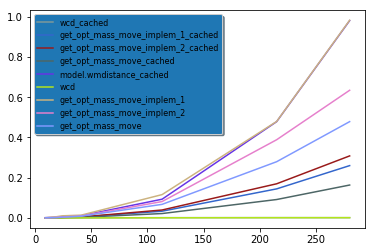

In [578]:
x = data[0, :, 1]
fn_names = ["wcd", "rwmd_implem_1", "rwmd_implem_2", "wrmd", "model.wmdistance"]

fig, ax = plt.subplots()
for i in range(data.shape[0]):
    ax.plot(x, data[i, :, 0] / 100, 'k', color=np.around(np.random.rand(3, 1), 1).flatten(), label=str(fn_names[i]+'_cached'))
for i in range(data_no_cache.shape[0]):
    ax.plot(x, data_no_cache[i, :, 0] / 10, 'k', color=np.around(np.random.rand(3, 1), 1).flatten(), label=fn_names[i])

legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large', prop={'size': 8})

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')